# Optimize a dense network with Bayesian optimization
Authors: Javier Duarte, Thong Nguyen

## Loading `pandas` DataFrames
Now we load two different `NumPy` arrays. One corresponding to the VV signal and one corresponding to the background.

In [1]:
import uproot
import numpy as np
import pandas as pd
import h5py

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

treename = 'HZZ4LeptonsAnalysisReduced'
filename = {}
upfile = {}
params = {}
df = {}

filename['VV'] = 'data/ntuple_4mu_VV.root'
filename['bkg'] = 'data/ntuple_4mu_bkg.root'

VARS = ['f_mass4l','f_massjj'] # choose which vars to use (2d)

upfile['VV'] = uproot.open(filename['VV'])
params['VV'] = upfile['VV'][treename].arrays(VARS)
upfile['bkg'] = uproot.open(filename['bkg'])
params['bkg'] = upfile['bkg'][treename].arrays(VARS)

df['VV'] = pd.DataFrame(params['VV'],columns=VARS)
df['bkg'] = pd.DataFrame(params['bkg'],columns=VARS)

# cut out undefined variables VARS[0] and VARS[1] > -999
df['VV']= df['VV'][(df['VV'][VARS[0]] > -999) & (df['VV'][VARS[1]] > -999)]
df['bkg']= df['bkg'][(df['bkg'][VARS[0]] > -999) & (df['bkg'][VARS[1]] > -999)] 

# add isSignal variable
df['VV']['isSignal'] = np.ones(len(df['VV'])) 
df['bkg']['isSignal'] = np.zeros(len(df['bkg'])) 

## Define the model
We'll start with a dense (fully-connected) NN layer.
Our model will have a single fully-connected hidden layer with the same number of neurons as input variables. 
The weights are initialized using a small Gaussian random number. 
We will switch between linear and tanh activation functions for the hidden layer.
The output layer contains a single neuron in order to make predictions. 
It uses the sigmoid activation function in order to produce a probability output in the range of 0 to 1.

We are using the `binary_crossentropy` loss function during training, a standard loss function for binary classification problems. 
We will optimize the model with the Adam algorithm for stochastic gradient descent and we will collect accuracy metrics while the model is trained.

In [2]:
# baseline keras model
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils
from keras import optimizers

NDIM = len(VARS)
inputs = Input(shape=(NDIM,), name = 'input')  
outputs = Dense(1, name = 'output', kernel_initializer='normal', activation='sigmoid')(inputs)

# creae the model
model = Model(inputs=inputs, outputs=outputs)
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# print the model summary
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2)                 0         
_________________________________________________________________
output (Dense)               (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing). 
We will also apply "standard scaling" preprocessing: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html i.e. making the mean = 0 and the RMS = 1 for all input variables (based **only** on the training/validation dataset).
We will also define our early stopping criteria to prevent over-fitting and we will save the model based on the best `val_loss`.

In [3]:
df_all = pd.concat([df['VV'],df['bkg']])
dataset = df_all.values
X = dataset[:,0:NDIM]
Y = dataset[:,NDIM]

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

# preprocessing: standard scalar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

# early stopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into dense_model.h5
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('dense_model.h5', monitor='val_loss', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)

## Run training 
Here, we run the training.

In [4]:
# Train classifier
import time
begt = time.time()
history = model.fit(X_train_val, 
                    Y_train_val, 
                    epochs=100, 
                    batch_size=1024, 
                    verbose=0, # switch to 1 for more verbosity 
                    callbacks=[early_stopping, model_checkpoint], 
                    validation_split=0.25)
print("Finished in {}s".format(time.time()-begt))

Finished in 4.27239608765s


## Optimize the hyperparameters of the model
The hyperperparameters of the model that we weill optimize are the number of hidden layers `num_hidden`, the number of nodes in each layer `initial_node`, and the fraction of dropout `dropout`.

In [5]:
import sys
!{sys.executable} -m pip install scikit-optimize --user

You are using pip version 9.0.3, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

def build_custom_model(num_hiddens=2, initial_node=50, 
                          dropout=0.5):
    inputs = Input(shape=(NDIM,), name = 'input')
    for i in range(num_hiddens):
        hidden = Dense(int(round(initial_node/np.power(2,i))), activation='relu')(inputs if i==0 else hidden)
        hidden = Dropout(np.float32(dropout))(hidden)
    outputs = Dense(1, name = 'output', kernel_initializer='normal', activation='sigmoid')(hidden)
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

def train(batch_size=1000):
    history = model.fit(X_train_val, 
                    Y_train_val, 
                    epochs=100, 
                    batch_size=batch_size, 
                    verbose=0, # switch to 1 for more verbosity 
                    callbacks=[early_stopping, model_checkpoint], 
                    validation_split=0.25)
    best_acc = max(history.history['val_acc'])
    return best_acc

space  = [Integer(1, 3, name='hidden_layers'),
          Integer(5, 100, name='initial_nodes'),
          Real(0.0,0.9,name='dropout'),
          Integer(500,5000,name='batch_size'),
          Real(10**-5, 10**-1, "log-uniform", name='learning_rate'),
          ]

@use_named_args(space)
def objective(**X):
    print("New configuration: {}".format(X))

    model = build_custom_model(num_hiddens=X['hidden_layers'], initial_node=X['initial_nodes'], 
                      dropout=X['dropout'])

    model.compile(optimizer=optimizers.Adam(lr=X['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    best_acc = train(batch_size=X['batch_size'])
        
    print("Best acc: {}".format(best_acc))
    return -best_acc

begt = time.time()
res_gp = gp_minimize(objective, space, n_calls=20, random_state=3)
print("Finish optimization in {}s".format(time.time()-begt))

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-scikit-learn/0.19.1-ogkkac2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


New configuration: {'dropout': 0.10919572308469448, 'hidden_layers': 1, 'learning_rate': 0.0005600770399424082, 'batch_size': 3062, 'initial_nodes': 85}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 85)                255       
_________________________________________________________________
dropout_1 (Dropout)          (None, 85)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 86        
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________
Best acc: 0.93008680942
New configuration: {'dropout': 0.22309946750343207, 'hidden_layers': 1, 'learning_rate': 0.00601581

Best acc: 0.949373170978
New configuration: {'dropout': 0.6422091724381469, 'hidden_layers': 2, 'learning_rate': 0.00018326055021161485, 'batch_size': 604, 'initial_nodes': 80}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 80)                240       
_________________________________________________________________
dropout_13 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 40)                3240      
_________________________________________________________________
dropout_14 (Dropout)         (None, 40)                0         
_________________________________________________________________
output (Dense)               (N

Best acc: 0.951542913914
New configuration: {'dropout': 0.9, 'hidden_layers': 3, 'learning_rate': 0.1, 'batch_size': 500, 'initial_nodes': 5}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2)                 0         
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 15        
_________________________________________________________________
dropout_28 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 12        
_________________________________________________________________
dropout_29 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 3         


Best acc: 0.951542913914
Finish optimization in 52.8855412006s


## Visualize the improvement
Let's see how Bayesian optimization improves the accuracy

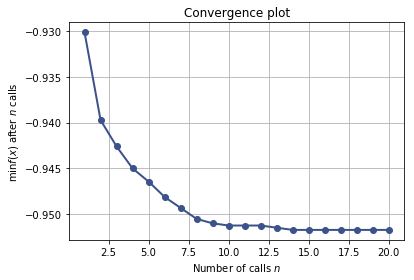

In [10]:
from skopt.plots import plot_convergence
plot_convergence(res_gp)

In [8]:
print("Best parameters: \
\nbest_hidden_layers = {} \
\nbest_initial_nodes = {} \
\nbest_dropout = {} \
\nbest_batch_size = {} \
\nbest_learning_rate = {}".format(res_gp.x[0],
                                 res_gp.x[1],
                                 res_gp.x[2],
                                 res_gp.x[3],
                                 res_gp.x[4]))


Best parameters: 
best_hidden_layers = 1 
best_initial_nodes = 16 
best_dropout = 0.573467215237 
best_batch_size = 4791 
best_learning_rate = 0.0928026955745


## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

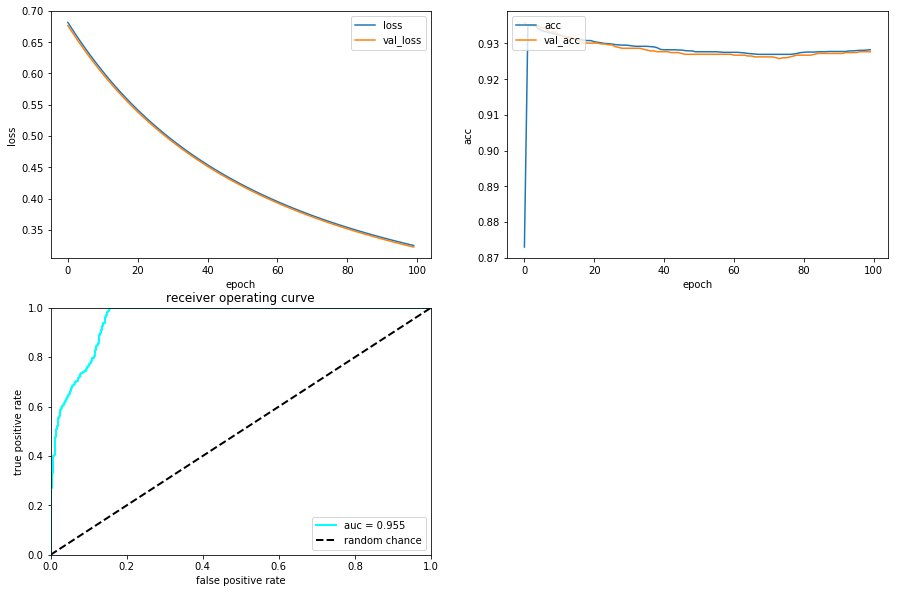

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history['acc'], label='acc')
ax.plot(history.history['val_acc'], label='val_acc')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot ROC
Y_predict = model.predict(X_test)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
ax = plt.subplot(2, 2, 3)
ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.set_title('receiver operating curve')
ax.legend(loc="lower right")
plt.show()